# GANs

Use the "Run" button to execute the code.

In [2]:
!pip install jovian --upgrade --quiet

In [3]:
import jovian

In [38]:
# Execute this to save new versions of the notebook
jovian.commit(project="artworkgan")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/noumanamir453/artworkgan


'https://jovian.ai/noumanamir453/artworkgan'

In [5]:
!pip install opendatasets --upgrade --quiet

In [6]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/ikarus777/best-artworks-of-all-time'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: noumanamir
Your Kaggle Key: ··········


100%|██████████| 2.29G/2.29G [00:54<00:00, 45.0MB/s]


In [9]:
import os

DATA_DIR = './best-artworks-of-all-time'
print(os.listdir(DATA_DIR))

['resized', 'artists.csv', 'images']


In [10]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [11]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [12]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [13]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

# Helper Functions

In [14]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [15]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


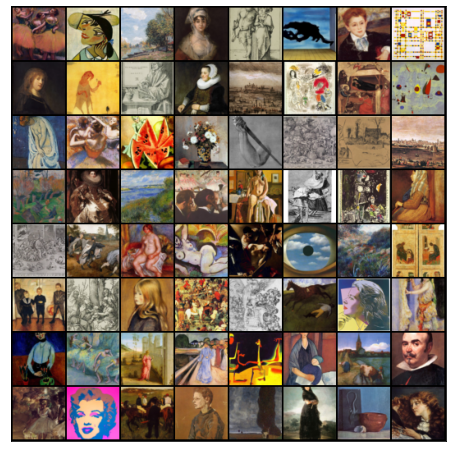

In [16]:
show_batch(train_dl)

# Using a GPU

In [17]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [18]:
device = get_default_device()
device

device(type='cuda')

In [19]:
train_dl = DeviceDataLoader(train_dl, device)

# Discriminator Network

In [20]:
import torch.nn as nn

In [21]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [22]:
discriminator = to_device(discriminator, device)

# Generator Network

In [23]:
latent_size = 128

In [24]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [25]:
generator = to_device(generator, device)

# Discriminator Training

In [26]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

# Generator Training

In [27]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [28]:
from torchvision.utils import save_image

In [29]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [30]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [31]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

# Full Training Loop

In [32]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [33]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [41]:
lr = 0.0002
epochs = 50

In [35]:
jovian.reset()
jovian.log_hyperparams(lr=lr, epochs=epochs)

[jovian] Hyperparams logged.


In [42]:
history = fit(epochs, lr)

  0%|          | 0/137 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [1/50], loss_g: 4.2655, loss_d: 0.5562, real_score: 0.8597, fake_score: 0.2815
Saving generated-images-0001.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 3.8159, loss_d: 0.4609, real_score: 0.7191, fake_score: 0.0712
Saving generated-images-0002.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 4.1107, loss_d: 0.3840, real_score: 0.8626, fake_score: 0.1861
Saving generated-images-0003.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 2.7328, loss_d: 0.4731, real_score: 0.7669, fake_score: 0.1458
Saving generated-images-0004.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 1.8993, loss_d: 0.9203, real_score: 0.5022, fake_score: 0.0876
Saving generated-images-0005.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 3.6321, loss_d: 0.2379, real_score: 0.8772, fake_score: 0.0828
Saving generated-images-0006.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 2.6643, loss_d: 0.5353, real_score: 0.7352, fake_score: 0.1533
Saving generated-images-0007.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 4.4300, loss_d: 0.3435, real_score: 0.8548, fake_score: 0.1546
Saving generated-images-0008.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 5.1281, loss_d: 0.2645, real_score: 0.9189, fake_score: 0.1511
Saving generated-images-0009.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 2.6989, loss_d: 0.3162, real_score: 0.8484, fake_score: 0.1220
Saving generated-images-0010.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 5.2993, loss_d: 0.1769, real_score: 0.8733, fake_score: 0.0335
Saving generated-images-0011.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 4.3643, loss_d: 0.6465, real_score: 0.9181, fake_score: 0.3861
Saving generated-images-0012.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 4.6827, loss_d: 0.6045, real_score: 0.9235, fake_score: 0.3624
Saving generated-images-0013.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 3.4254, loss_d: 0.4538, real_score: 0.7054, fake_score: 0.0720
Saving generated-images-0014.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 1.2622, loss_d: 0.6549, real_score: 0.6179, fake_score: 0.0956
Saving generated-images-0015.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 3.8084, loss_d: 0.3081, real_score: 0.8636, fake_score: 0.1225
Saving generated-images-0016.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 7.4519, loss_d: 1.1105, real_score: 0.9608, fake_score: 0.5938
Saving generated-images-0017.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 4.5671, loss_d: 0.2350, real_score: 0.9744, fake_score: 0.1756
Saving generated-images-0018.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 1.5910, loss_d: 0.6330, real_score: 0.6196, fake_score: 0.0728
Saving generated-images-0019.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 2.6356, loss_d: 0.5275, real_score: 0.6581, fake_score: 0.0466
Saving generated-images-0020.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 2.8126, loss_d: 0.2393, real_score: 0.9611, fake_score: 0.1585
Saving generated-images-0021.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 2.8179, loss_d: 0.3831, real_score: 0.7598, fake_score: 0.0692
Saving generated-images-0022.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 4.7851, loss_d: 0.1340, real_score: 0.9163, fake_score: 0.0411
Saving generated-images-0023.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 2.2603, loss_d: 0.5413, real_score: 0.7136, fake_score: 0.1076
Saving generated-images-0024.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 1.4085, loss_d: 0.5250, real_score: 0.8241, fake_score: 0.2424
Saving generated-images-0025.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 2.0155, loss_d: 1.8172, real_score: 0.2292, fake_score: 0.0005
Saving generated-images-0026.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 3.7510, loss_d: 0.2315, real_score: 0.9656, fake_score: 0.1665
Saving generated-images-0027.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 4.6401, loss_d: 0.4057, real_score: 0.9474, fake_score: 0.2654
Saving generated-images-0028.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 3.8167, loss_d: 0.3134, real_score: 0.7969, fake_score: 0.0611
Saving generated-images-0029.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 2.9526, loss_d: 0.1832, real_score: 0.9082, fake_score: 0.0786
Saving generated-images-0030.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 2.2372, loss_d: 1.8478, real_score: 0.2221, fake_score: 0.0023
Saving generated-images-0031.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 2.0180, loss_d: 0.3841, real_score: 0.7343, fake_score: 0.0345
Saving generated-images-0032.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 3.2466, loss_d: 0.2074, real_score: 0.9910, fake_score: 0.1674
Saving generated-images-0033.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 7.2905, loss_d: 0.0783, real_score: 0.9362, fake_score: 0.0112
Saving generated-images-0034.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 1.9205, loss_d: 0.4987, real_score: 0.6825, fake_score: 0.0340
Saving generated-images-0035.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 4.0428, loss_d: 0.3010, real_score: 0.9866, fake_score: 0.2322
Saving generated-images-0036.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 3.9823, loss_d: 0.2187, real_score: 0.9411, fake_score: 0.1328
Saving generated-images-0037.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 4.5762, loss_d: 0.4412, real_score: 0.9075, fake_score: 0.2548
Saving generated-images-0038.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 3.6767, loss_d: 0.2445, real_score: 0.8176, fake_score: 0.0288
Saving generated-images-0039.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 3.6574, loss_d: 0.3259, real_score: 0.7561, fake_score: 0.0207
Saving generated-images-0040.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 3.2831, loss_d: 0.2194, real_score: 0.8404, fake_score: 0.0301
Saving generated-images-0041.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 4.2891, loss_d: 0.2363, real_score: 0.8909, fake_score: 0.0959
Saving generated-images-0042.png


  0%|          | 0/137 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4d6fcc2710>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4d6fcc2710>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

Epoch [43/50], loss_g: 2.9983, loss_d: 0.2588, real_score: 0.9170, fake_score: 0.1430
Saving generated-images-0043.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 3.2260, loss_d: 0.5922, real_score: 0.7825, fake_score: 0.1883
Saving generated-images-0044.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 3.6353, loss_d: 0.2005, real_score: 0.9225, fake_score: 0.1038
Saving generated-images-0045.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 2.4881, loss_d: 0.2833, real_score: 0.8689, fake_score: 0.1036
Saving generated-images-0046.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 1.7050, loss_d: 0.3493, real_score: 0.7885, fake_score: 0.0822
Saving generated-images-0047.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 3.4082, loss_d: 0.3017, real_score: 0.9023, fake_score: 0.1565
Saving generated-images-0048.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 2.5365, loss_d: 0.0960, real_score: 0.9663, fake_score: 0.0558
Saving generated-images-0049.png


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 3.6542, loss_d: 0.1536, real_score: 0.8969, fake_score: 0.0390
Saving generated-images-0050.png


In [43]:
losses_g, losses_d, real_scores, fake_scores = history

In [44]:
jovian.log_metrics(loss_g=losses_g[-1], 
                   loss_d=losses_d[-1], 
                   real_score=real_scores[-1], 
                   fake_score=fake_scores[-1])

[jovian] Metrics logged.


In [45]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [46]:
from IPython.display import Image

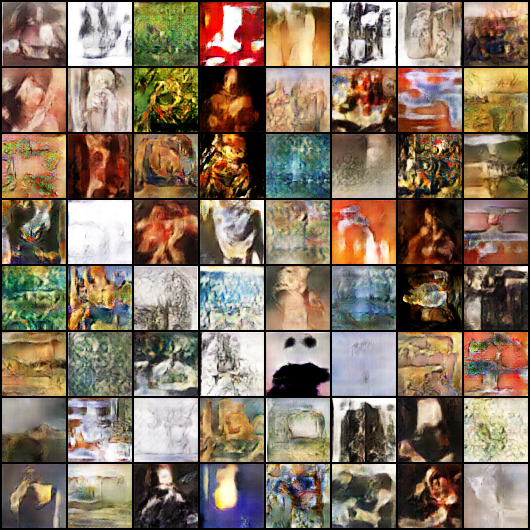

In [48]:
Image('./generated/generated-images-0050.png')

In [49]:
import cv2
import os

vid_fname = 'gans_training_2.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

In [51]:
jovian.commit(project="gan", 
              outputs=['G.pth', 'D.pth', 'gans_training_2.avi'], 
              environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/noumanamir453/gan


'https://jovian.ai/noumanamir453/gan'